<a href="https://colab.research.google.com/github/vuchicago/Keras/blob/master/rmx_indvchar_categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive') ##Mount Drive

import numpy as np
import pandas as pd
from sklearn.utils import shuffle

df=pd.read_csv("rmxproducts.csv")
df=df.dropna()
df = shuffle(df)
train_size=np.int(df.shape[0]//(10/9))  ###Training size is 9/10 of dataset
print("dset size =",df.shape[0], ";training size = ",train_size, "; test size= ",df.shape[0]-train_size)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
dset size = 5338 ;training size =  4804 ; test size=  534


In [0]:

##Features is a series of descriptions 
features=list(df["Features"])
labels=df["Labels"]

cv=features[:train_size]
test=features[train_size:]
labels_cv=labels[:train_size]
labels_test=labels[train_size:]

In [0]:
#Split each sentence into words in a list
word_dic=[]
for lines in features:
  for words in list(lines):
    word_dic.append(words.replace(" ","")) #gets rid of all the spaces
    


In [4]:
word_dic_unq=pd.Series(word_dic).unique() #get only the unique words in the list
len(word_dic_unq)




52

In [0]:
####CREATES A DICTIONARY OF ALL THE UNIQUE words
word2index={}
index2word={}
for index, word in enumerate(word_dic_unq):
  word2index[word]=index
  index2word[index]=word



In [6]:
##Converts each line to its character and sums up the amount of characters in the dictionary a line has if it has multiple
def conv2inputs(dataset):
  zeros_matrix=np.zeros([len(dataset),len(word2index)])
  for num,lines in enumerate(dataset):
    for words in list(lines):
      indicator=word2index[words.replace(" ","")] #convert words to index number in dictionary above
      zeros_matrix[num,indicator]+=1
  return zeros_matrix
dset=conv2inputs(features)   

dset_cv=conv2inputs(cv)
dset_test=conv2inputs(test)


print(dset)

[[ 2.  8.  2. ...  0.  0.  0.]
 [ 1. 13.  1. ...  0.  0.  0.]
 [ 0.  4.  0. ...  0.  0.  0.]
 ...
 [ 1.  6.  1. ...  0.  0.  0.]
 [ 1.  4.  1. ...  0.  0.  0.]
 [ 0.  3.  3. ...  0.  0.  0.]]


In [7]:
###CREATE ONE HOT VECTOR FOR LABELS
from keras.utils import to_categorical
#labels_array=np.array(labels)
#one_hot_labels = to_categorical(labels_array)

label_dic_unq=pd.Series(labels).unique() #CREATE A DICTIONARY OF UNIQUE LABELS

label2index={}
index2label={}
for index, word in enumerate(label_dic_unq):
  label2index[word]=index
  index2label[index]=word

def label2inputs(dataset):
  one_hot_labels=np.zeros([dataset.shape[0],len(label2index)])

  for num,label in enumerate(dataset):
    indicator=label2index[label]
    one_hot_labels[num,indicator]=1
  return one_hot_labels

one_hot_labels_cv=label2inputs(labels_cv)
one_hot_labels_test=label2inputs(labels_test)

Using TensorFlow backend.


In [8]:
from keras import Sequential,models
from keras.layers import Dropout,Dense, Embedding
from keras import optimizers, regularizers
sgd=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

def keras_model():
  model=models.Sequential()
  model.add(Dense(256,kernel_regularizer=regularizers.l2(.001),input_shape=(len(word2index),), activation="relu"))
  model.add(Dropout(.2))
  model.add(Dense(256, activation='tanh'))
  model.add(Dropout(.2))
  model.add(Dense(128, kernel_regularizer=regularizers.l2(.001),activation='relu'))
  model.add(Dense(128,activation='relu'))
  model.add(Dropout(.2))
  model.add(Dense(128,activation='relu'))
  model.add(Dense(26,activation="softmax"))
  model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
  return model




Instructions for updating:
Colocations handled automatically by placer.


In [27]:
from keras import Sequential,models
from keras.layers import Dropout,Dense
from keras import optimizers, regularizers
sgd=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)




fold=100
epoch=30
sample_size=len(dset_cv)//fold
train_history=[]
val_history=[]
train_history_loss=[]
val_history_loss=[]

for i in range(fold):
  print('processing fold #',i)
  X_val=dset_cv[i*sample_size: (i+1)*sample_size]
  y_val=one_hot_labels_cv[i*sample_size: (i+1)*sample_size]
  
  X_train=np.concatenate([dset_cv[:i*sample_size],dset_cv[(i+1)*sample_size:]],axis=0)
  y_train=np.concatenate([one_hot_labels_cv[:i*sample_size],one_hot_labels_cv[(i+1)*sample_size:]],axis=0)
  
  history=keras_model().fit(X_train,y_train,epochs=epoch,batch_size=512,validation_data=[X_val,y_val])
  
  ###get the losses and accuracy for the train & validation for each epoch
  train_acc=history.history["acc"]
  val_acc=history.history['val_acc']

  train_loss=history.history['loss']
  val_loss=history.history['val_loss']
  
  train_history.append(train_acc)
  val_history.append(val_acc)
  train_history_loss.append(train_loss)
  val_history_loss.append(val_loss)

#from sklearn.model_selection import KFold
#kf = KFold(n_splits=5)
#KFold(n_splits=5, random_state=None, shuffle=False)
#accuracy=[]
#for train_index, test_index in kf.split(dset_cv):
  #X_train, X_val = dset_cv[train_index], dset_cv[test_index]
  #y_train, y_val = one_hot_labels_cv[train_index], one_hot_labels_cv[test_index]




'''
  model=models.Sequential()
  model.add(Dense(512,kernel_regularizer=regularizers.l2(.001), activation="relu",input_shape=(len(word2index),)))
  model.add(Dropout(.2))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(.1))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128,kernel_regularizer=regularizers.l2(.001),activation='relu'))
  model.add(Dense(26,activation="softmax"))

  model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])'''

  


processing fold # 0
Train on 4756 samples, validate on 48 samples
Epoch 1/30
4756/4756 [==============================] - 4s 763us/step - loss: 3.0612 - acc: 0.1941 - val_loss: 2.8468 - val_acc: 0.2292
Epoch 2/30
4756/4756 [==============================] - 0s 19us/step - loss: 2.6892 - acc: 0.2813 - val_loss: 2.5660 - val_acc: 0.3333
Epoch 3/30
4756/4756 [==============================] - 0s 18us/step - loss: 2.4418 - acc: 0.3509 - val_loss: 2.3605 - val_acc: 0.2917
Epoch 4/30
4756/4756 [==============================] - 0s 18us/step - loss: 2.2588 - acc: 0.3993 - val_loss: 2.1938 - val_acc: 0.2917
Epoch 5/30
4756/4756 [==============================] - 0s 19us/step - loss: 2.1106 - acc: 0.4336 - val_loss: 2.1235 - val_acc: 0.3750
Epoch 6/30
4756/4756 [==============================] - 0s 19us/step - loss: 1.9951 - acc: 0.4575 - val_loss: 1.9990 - val_acc: 0.4792
Epoch 7/30
4756/4756 [==============================] - 0s 19us/step - loss: 1.9007 - acc: 0.4897 - val_loss: 1.8890 - val_

'\n  model=models.Sequential()\n  model.add(Dense(512,kernel_regularizer=regularizers.l2(.001), activation="relu",input_shape=(len(word2index),)))\n  model.add(Dropout(.2))\n  model.add(Dense(256, activation=\'relu\'))\n  model.add(Dropout(.1))\n  model.add(Dense(128, activation=\'relu\'))\n  model.add(Dense(128,kernel_regularizer=regularizers.l2(.001),activation=\'relu\'))\n  model.add(Dense(26,activation="softmax"))\n\n  model.compile(optimizer=sgd,loss=\'categorical_crossentropy\',metrics=[\'accuracy\'])'

In [29]:


average_train_loss=[np.mean([x[i] for x in train_history_loss]) for i in range(epoch)]
average_val_loss=[np.mean([x[i] for x in val_history_loss]) for i in range(epoch)]

average_train_acc=[np.mean([x[i] for x in train_history]) for i in range(epoch)]
average_val_acc=[np.mean([x[i] for x in val_history]) for i in range(epoch)]

average_train_acc
average_val_acc

[0.31270833387970925,
 0.3868749998509884,
 0.4564583320915699,
 0.5047916686534881,
 0.5475000008940697,
 0.5812500029802322,
 0.6120833343267441,
 0.6320833334326744,
 0.6541666665673256,
 0.6616666653752327,
 0.6758333319425582,
 0.6856249958276749,
 0.6958333307504654,
 0.7024999961256981,
 0.7075000023841858,
 0.7177083343267441,
 0.7235416665673255,
 0.728125,
 0.7258333331346511,
 0.7356249994039535,
 0.7360416680574418,
 0.736666664481163,
 0.7410416683554649,
 0.7447916662693024,
 0.742708330154419,
 0.7481249964237213,
 0.7489583340287208,
 0.7514583331346512,
 0.7539583346247674,
 0.7510416662693024]

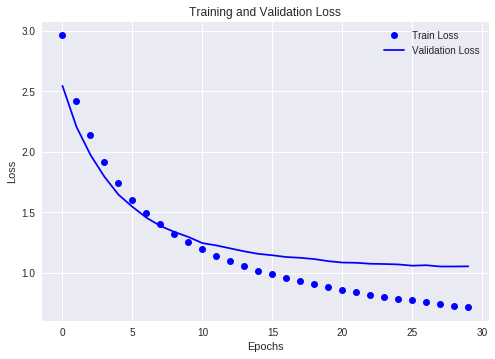

In [30]:
import matplotlib.pyplot as plt
epochs=range(0,epoch)
plt.plot(epochs,average_train_loss,'bo', label="Train Loss")
plt.plot(epochs,average_val_loss,'b',label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

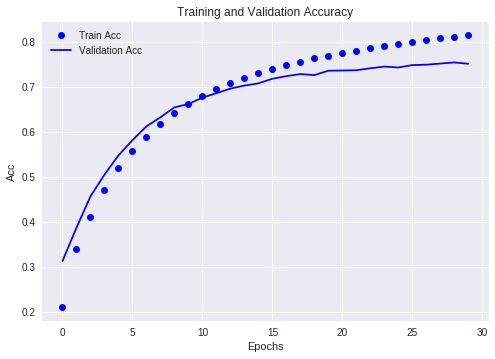

In [31]:
##LOSS FOR THE LAST FOLD IN KFOLD CV
import matplotlib.pyplot as plt
history_dict=history.history
epochs=range(0,epoch)
plt.plot(epochs,average_train_acc,'bo', label="Train Acc")
plt.plot(epochs,average_val_acc,'b',label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.legend()
plt.show()

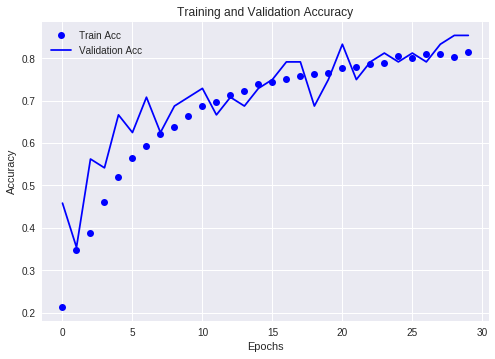

In [32]:
###ACCURACY FOR THE LAST FOLD IN KFOLD CV

acc_vlues=train_acc
val_acc_values=val_acc
plt.plot(epochs,train_acc,'bo', label="Train Acc")
plt.plot(epochs,val_acc_values,'b',label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [33]:
from keras.models import load_model
"""del model
model=load_model("trained_model.h5")
"""
model=keras_model()


#model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

history=model.fit(dset_cv,one_hot_labels_cv,epochs=epoch,batch_size=512,validation_data=[dset_test,one_hot_labels_test])

  


Train on 4804 samples, validate on 534 samples
Epoch 1/30
4804/4804 [==============================] - 26s 5ms/step - loss: 2.9185 - acc: 0.2140 - val_loss: 2.4352 - val_acc: 0.3652
Epoch 2/30
4804/4804 [==============================] - 0s 24us/step - loss: 2.4113 - acc: 0.3381 - val_loss: 2.0657 - val_acc: 0.4363
Epoch 3/30
4804/4804 [==============================] - 0s 25us/step - loss: 2.1197 - acc: 0.4074 - val_loss: 1.8380 - val_acc: 0.5075
Epoch 4/30
4804/4804 [==============================] - 0s 27us/step - loss: 1.8959 - acc: 0.4744 - val_loss: 1.6380 - val_acc: 0.5375
Epoch 5/30
4804/4804 [==============================] - 0s 25us/step - loss: 1.7187 - acc: 0.5237 - val_loss: 1.4730 - val_acc: 0.6124
Epoch 6/30
4804/4804 [==============================] - 0s 25us/step - loss: 1.5751 - acc: 0.5729 - val_loss: 1.3872 - val_acc: 0.6273
Epoch 7/30
4804/4804 [==============================] - 0s 24us/step - loss: 1.4532 - acc: 0.6003 - val_loss: 1.2833 - val_acc: 0.6648
Epoch 8/

In [34]:
model.predict(dset_test)
history_keys=history.history
history_keys['val_acc']


[0.36516853966070023,
 0.43632958790336207,
 0.5074906365925007,
 0.5374531824044074,
 0.6123595514547512,
 0.6273408230770839,
 0.6647940072673983,
 0.6591760297393084,
 0.6853932582037279,
 0.6910112357318178,
 0.7097378268224023,
 0.7209737825482972,
 0.7078651694322793,
 0.7453183518366867,
 0.7434456926606567,
 0.7134831458441774,
 0.7490636695190316,
 0.7378277144628518,
 0.7453183518366867,
 0.7322097387206689,
 0.7340823961107918,
 0.7509363304809684,
 0.7453183511669716,
 0.7453183511669716,
 0.7490636695190316,
 0.7602996245752113,
 0.775280897983451,
 0.7565543068928665,
 0.7602996245752113,
 0.7565543062231513]

In [16]:
df[0:10]

,Features,Labels,lookup
873,"1009N4H - 10000,STDIN,80ETH,ZT40,L9",NAS : Non-Air Standard,793.0
3383,"000000000045697214 - 4500,PERFORM65,65B60BH,Z...",FLO : Flowabilty,440.0
1161,"4085CETE - 4000,FTB FILL,65BETN,Z,3",FLO : Flowabilty,440.0
984,"2451. - 3000,B4.0,6050M,ZC20G",AS. : Air Standard,1110.0
3373,"000000000045687702 - 4500,PERFORM63,40BET,ZS35,L",NAS : Non-Air Standard,793.0
1613,"9583. - 4500,B6.5,7045BH,ZF20L",FLO : Flowabilty,440.0
5082,"SCCHPC-1 - 4000,SCCHPC-1,S6CAEBH,ZC20,G9",AGI : Agilia,42.0
557,"61N25IN - B6.0,STDIN,40ETL,EF25",CC. : Cement Content,216.0
40,"3A32-2 - 3900,3A32-2,3065BL,EF15",SA. : Strength Authority,844.0
3934,"HE3COF - 4000,FASTSET,2065BL,E",CC. : Cement Content,216.0


In [0]:
dset_check=conv2inputs(["430602. - 4000,LIGHT WTI,50B30BA,5F10"])

In [0]:
prediction=model.predict(dset_test) ##Get the numerical value of all test examples in a matrix (n x labels)


In [0]:
pred=np.argmax(prediction,axis=1) ###get the index corresponding to the highest value of each prediction (n x 1)

#indices = [i for i,v in enumerate(pred) if pred[i]==label2index[list(labels_test)[i]]]
indices=[i for i,v in enumerate(pred)] 
predicted_labels=pd.Series([index2label[pred[index]] for index in indices ]) ##output the labels from the pred index
subset_of_wrongly_predicted_labels = pd.Series([list(labels_test)[i] for i in indices ]) ##actual labels from test dataset
subset_of_wrongly_features = pd.Series([test[i] for i in indices ]) ##features from the test dset

In [0]:

a=pd.concat([subset_of_wrongly_features,subset_of_wrongly_predicted_labels, predicted_labels],axis=1) #concat feature, actuals, prediction




In [0]:
from google.colab import files
files.download("predictedvsactual_all.csv")

In [49]:
test

['000000000030600314 -  3000,PERFORM56,65B60BH,ZS50,G',
 'ALDI-1 -  3000,SALESFLOOR,50ETL,E',
 '3R57C-HE2 -  4000,3R57C-HE2,20AEBN,Z,G9',
 '000000000035657702 -  3500,PERFORM55,40ETL,ZS25L',
 '3F32-F3 -  4500,3F32-F3,3065L,EF15',
 '6BAGFNA -  3000,FINEGROUT,65BETL,ZF15',
 '6579. -  3500,B5.5,4045BL,ZF20L1',
 '6420023. -  4000,WC45,4060BN,Z',
 '4586. -  3500,B5.75,60M,ZF15L',
 '304530MR -  3000,REG,5060BM,ZF20',
 '271. -  4500,B5.5,4060N,ZC20L',
 '5256140. -  2500,REG,4060BL,ZF20',
 '409304. -  4000,REG,40ETL,2F15,9',
 'RMXEUS4012 -  3000,AGILIA AUGER CAST,T1ETH,Z',
 'SLP3NH2 -  4000,C-SERIES SLAB,50ETM,ZC15,G9',
 '1450100. -  4500,SHOTCRETE,5040N,Z',
 '454N1H-P -  4500,STDIN,60ETM,ZC10,G9',
 '100NHB1 -  5000,PUMP,70ETM,ZC20,G3B1',
 '9980MG -  4000,TDOT P(H),4545BL,ZF25,L1U',
 '408309SC -  4000,SCC,S760BH,ZF30,V',
 '704338. -  7000,PERFORM,6050H,ZF30',
 'MD3825SF -  3500,S3W-N50-12-67 SF',
 'GREY1 -  4500,TOPPING,60ETH,EF25',
 'MN92 -  4000,SHOTCRETE,20AEBM,ZC15,G3',
 '4568F712 -  4500,